<h2>Cancer Cell Detection with Support Vector Machines (SVMs) </h2>
The project is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007) [http://mlearn.ics.uci.edu/MLRepository.html]. 

The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:


|Field name|Description|
|--- |--- |
|ID|Clump thickness|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ds = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/cell_samples.csv')
ds.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

In [3]:
ds.describe()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BlandChrom,NormNucl,Mit,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [4]:
ds.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

BareNuc column seems to have non-numeric values which are unsuitable for our training, we will investigate further into this.

In [5]:
ds['BareNuc'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

It contains '?' as a value in some rows. We will drop these rows for training.

In [6]:
ds = ds[ds['BareNuc'] != '?']
ds['BareNuc'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '5', '8', '6'], dtype=object)

Now, BareNuc can easily be converted to a numeric data type.

In [7]:
ds['BareNuc'] = ds['BareNuc'].astype('int')
ds.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [8]:
ds.shape

(683, 11)

Let's plot correlation values to determine training set features.

<Axes: >

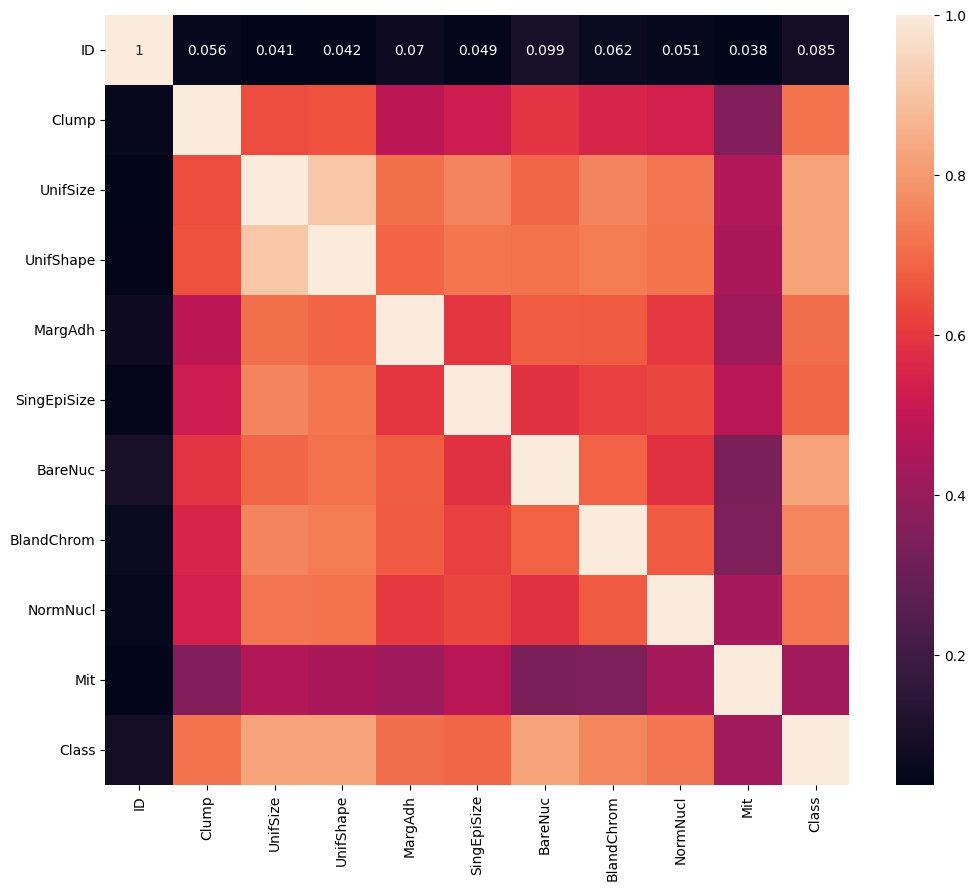

In [9]:
from seaborn import heatmap

plt.figure(figsize=(12,10))
heatmap(ds.corr().abs(), annot=True)

'ID' and 'Mit' do not seem to have relevant impact on 'Class', so we will exclude those in our training set.

In [10]:
ds.columns

Index(['ID', 'Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize',
       'BareNuc', 'BlandChrom', 'NormNucl', 'Mit', 'Class'],
      dtype='object')

In [11]:
# Training features
X = np.asarray(ds[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl']])
X

array([[ 5,  1,  1, ...,  1,  3,  1],
       [ 5,  4,  4, ..., 10,  3,  2],
       [ 3,  1,  1, ...,  2,  3,  1],
       ...,
       [ 5, 10, 10, ...,  3,  8, 10],
       [ 4,  8,  6, ...,  4, 10,  6],
       [ 4,  8,  8, ...,  5, 10,  4]], dtype=int64)

In [12]:
# Target variable
Y = np.asarray(ds['Class'])
Y[:5]

array([2, 2, 2, 2, 2], dtype=int64)

In [13]:
# Normalizing data
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)
X

array([[ 0.19790469, -0.70221201, -0.74177362, ..., -0.69885309,
        -0.18182716, -0.61292736],
       [ 0.19790469,  0.27725185,  0.26278299, ...,  1.77286724,
        -0.18182716, -0.28510482],
       [-0.51164337, -0.70221201, -0.74177362, ..., -0.4242175 ,
        -0.18182716, -0.61292736],
       ...,
       [ 0.19790469,  2.23617957,  2.2718962 , ..., -0.1495819 ,
         1.86073779,  2.33747554],
       [-0.15686934,  1.58320366,  0.93248739, ...,  0.12505369,
         2.67776377,  1.02618536],
       [-0.15686934,  1.58320366,  1.6021918 , ...,  0.39968928,
         2.67776377,  0.37054027]])

In [14]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.3, random_state=4)
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((478, 8), (478,), (205, 8), (205,))

sklearn's SVM models have different values for the hyperparameter __kernel__. We will train and evaluate model performance on each of these kernels and pick the best one.

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import jaccard_score, confusion_matrix, f1_score

kernel_array = ['rbf', 'linear', 'poly', 'sigmoid']
results = {}

for kernel in kernel_array:
    model = SVC(kernel=kernel).fit(xtrain, ytrain)
    yhat = model.predict(xtest)
    results[kernel] = {'jaccard_score': jaccard_score(ytest, yhat, pos_label=2), 
                       'f1_score': f1_score(ytest, yhat, average='weighted'),
                       'confusion_matrix': confusion_matrix(ytest, yhat, labels=[2,4])}

results

{'rbf': {'jaccard_score': 0.9037037037037037,
  'f1_score': 0.9371724039968712,
  'confusion_matrix': array([[122,  10],
         [  3,  70]], dtype=int64)},
 'linear': {'jaccard_score': 0.9111111111111111,
  'f1_score': 0.941938084007523,
  'confusion_matrix': array([[123,   9],
         [  3,  70]], dtype=int64)},
 'poly': {'jaccard_score': 0.927536231884058,
  'f1_score': 0.9510641441000877,
  'confusion_matrix': array([[128,   4],
         [  6,  67]], dtype=int64)},
 'sigmoid': {'jaccard_score': 0.9111111111111111,
  'f1_score': 0.941938084007523,
  'confusion_matrix': array([[123,   9],
         [  3,  70]], dtype=int64)}}

Best performance is by kernel = 'poly'. Therefore we will choose this model.

In [16]:
best_kernel = 'poly'

jaccscore = results[best_kernel]['jaccard_score']
f1score = results[best_kernel]['f1_score']
cm = results[best_kernel]['confusion_matrix']

In [17]:
jaccscore

0.927536231884058

In [18]:
f1score

0.9510641441000877

In [19]:
cm

array([[128,   4],
       [  6,  67]], dtype=int64)

<Axes: >

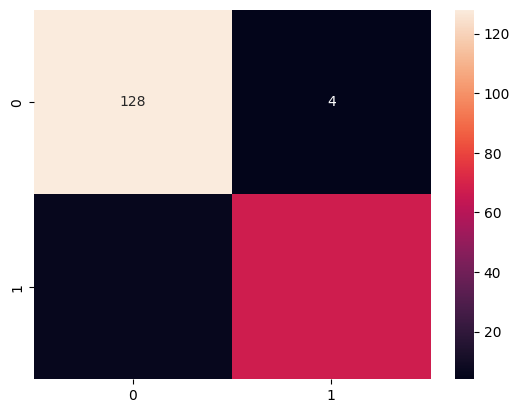

In [20]:
heatmap(cm, annot=True, fmt='.0f')

In [21]:
from sklearn.metrics import classification_report

model = SVC(kernel=best_kernel).fit(xtrain, ytrain)
yhat = model.predict(xtest)
print(classification_report(ytest, yhat))

              precision    recall  f1-score   support

           2       0.96      0.97      0.96       132
           4       0.94      0.92      0.93        73

    accuracy                           0.95       205
   macro avg       0.95      0.94      0.95       205
weighted avg       0.95      0.95      0.95       205

